In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Data Loading

In [2]:
train = pd.read_csv("malignant_train.csv")
test = pd.read_csv("malignant_test.csv")
test_y = pd.read_csv("malignant_test_labels.csv")
print(train.shape)
print(test.shape)

(159571, 8)
(153164, 2)


In [3]:
print(train.dtypes)

id                  object
comment_text        object
malignant            int64
highly_malignant     int64
rude                 int64
threat               int64
abuse                int64
loathe               int64
dtype: object


In [4]:
train = train.reindex(np.random.permutation(train.index))

### Data Analysis

In [5]:
train.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
136802,dbd1bcabf8a75320,"""\nHi Peripitus, The images added have been us...",0,0,0,0,0,0
21578,38d9456b24e45e2e,All VHS in 1990 or 1991 that has a vertical wh...,0,0,0,0,0,0
41,00173958f46763a2,TFD \n\nI think we just eced. I think we respo...,0,0,0,0,0,0
145547,1e4e79fe0e7a51c7,"""Eh.. I was reading in the president section, ...",0,0,0,0,0,0
40888,6d222f359bb2cc03,). Fine play sheriff. We are an encyclopedia...,0,0,0,0,0,0


In [6]:
train.describe()

,malignant,highly_malignant,rude,threat,abuse,loathe
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


Notice that the training data contains 159,571 observations with 8 columns and the test data contains 153,164 observations with 2 columns.

<AxesSubplot:xlabel='comment_text'>

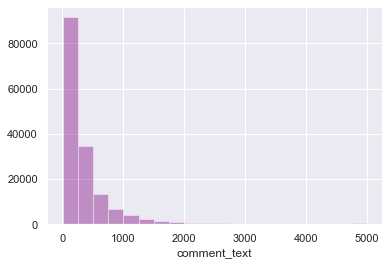

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
comment_len = train.comment_text.str.len()
sns.distplot(comment_len, kde=False, bins=20, color="purple")

Further exploratory shows that label malignant has the most observations in the training dataset while threat has the least.

In [9]:
train_labels = train[['malignant', 'highly_malignant' , 'rude' , 'threat' , 'abuse' , 'loathe']]
label_count = train_labels.sum()

<AxesSubplot:title={'center':'Labels Frequency'}>

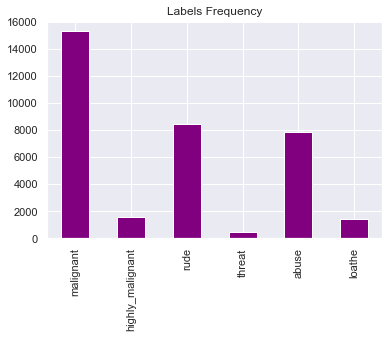

In [10]:
label_count.plot(kind='bar', title='Labels Frequency', color='purple')

Below is the plot for the labeled data frequency. There is significant class imbalance since majority of the comments are considered non-toxic.

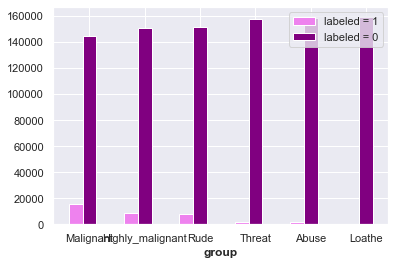

In [12]:
barWidth = 0.25

bars1 = [sum(train['malignant'] == 1), sum(train['rude'] == 1), sum(train['abuse'] == 1), sum(train['highly_malignant'] == 1),
         sum(train['loathe'] == 1), sum(train['threat'] == 1)]
bars2 = [sum(train['malignant'] == 0), sum(train['rude'] == 0), sum(train['abuse'] == 0), sum(train['highly_malignant'] == 0),
         sum(train['loathe'] == 0), sum(train['threat'] == 0)]

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='violet', width=barWidth, label='labeled = 1')
plt.bar(r2, bars2, color='purple', width=barWidth, label='labeled = 0')

plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Malignant', 'Highly_malignant' , 'Rude' , 'Threat' , 'Abuse' , 'Loathe'])
plt.legend()
plt.show()

To get a better understanding of what the comments look like, below are examples of one clean (non-toxic) comment and one toxic (specifically, with label "malignant") comment.

In [13]:
train.comment_text[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [14]:
train[train.malignant == 1].iloc[1, 1]

'Go fuck yourself you sick twisted sack of shite'

It might be a great practice to see which labels are likely to appear together with a comment.

<AxesSubplot:>

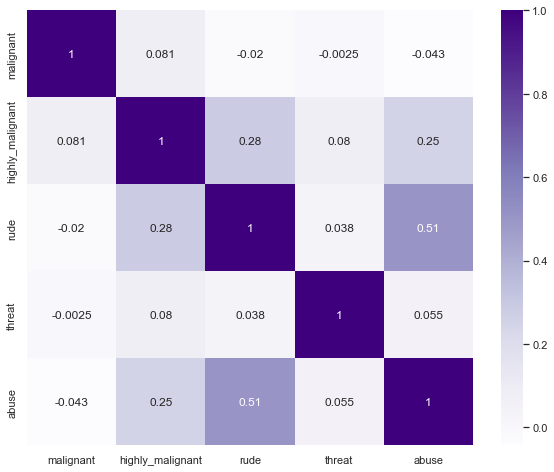

In [15]:
rowsums = train.iloc[:, 2:].sum(axis=1)
temp = train.iloc[:, 2:-1]
train_corr = temp[rowsums > 0]
corr = train_corr.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True, cmap="Purples")

As seen in the cross-correlation matrix, there is a high chance of obscene comments to be insulting.

In order to get an idea of what are the words that contribute the most to different labels, we write a function to generate word clouds. The function takes in a parameter label (i.e., malignant, abuse, threat, etc)

In [16]:
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from timeit import default_timer as timer

test_labels = ['malignant', 'highly_malignant' , 'rude' , 'threat' , 'abuse' , 'loathe']

In [17]:
def tokenize(text):
    
    text = text.lower()
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)
    words = nopunct.split(' ')
    
    words = [word.encode('ascii', 'ignore').decode('ascii') for word in words]
    lmtzr = WordNetLemmatizer()
    words = [lmtzr.lemmatize(w) for w in words]
    words = [w for w in words if len(w) > 2]
    return words

### Feature Engineering

Before fitting models, we need to break down the sentence into unique words by tokenizing the comments. In the tokenize() function, we remove punctuations and special characters. We also filtered out non-ascii characters after observing the results of feature engineering. We then lemmatize the comments and filter out comments with length below 3. Besides lemmatization, we also tried stemming but did not get a better result.

In [18]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer

vector = TfidfVectorizer(ngram_range=(1, 1), analyzer='word',
                         tokenizer=tokenize, stop_words='english',
                         strip_accents='unicode', use_idf=1, min_df=10)
X_train = vector.fit_transform(train['comment_text'])
X_test = vector.transform(test['comment_text'])

In [19]:
vector.get_feature_names()[0:20]

['aaa',
 'aap',
 'aardvark',
 'aaron',
 'aba',
 'abandon',
 'abandoned',
 'abandoning',
 'abandonment',
 'abbas',
 'abbey',
 'abbott',
 'abbreviated',
 'abbreviation',
 'abc',
 'abcnews',
 'abd',
 'abducted',
 'abduction',
 'abdul']

## Modeling and Evaluation
### Baseline Model
We choose Naive Bayes as our baseline model, specifically Multinomial Naive Bayes.

Also, we want to compare between different models, especially models that perform well in text classification. Thus, we choose to compare Multinomial Naive Bayes with Logistic Regression and Linear Support Vector Machine.

### Evaluation Metrics
Our main metric for measuring model performance is F1-score, since we have 6 labels, the F1-score would be the average of 6 labels. We will also take other metrics into consideration while evaluating models, e.g, Hamming loss and recall.


### Cross Validation
We use cross Validation to compare between the baseline model and the other two models that we have chosen (LogisticRegression and LinearSVC).

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score
from statistics import mean
from sklearn.metrics import hamming_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

from sklearn.metrics import roc_auc_score, confusion_matrix
import statistics
from sklearn.metrics import recall_score

clf1 = MultinomialNB()
clf2 = LogisticRegression()
clf3 = LinearSVC()

In [21]:
def cross_validation_score(classifier, X_train, y_train):
   
    methods = []
    name = classifier.__class__.__name__.split('.')[-1]

    for label in test_labels:
        recall = cross_val_score(
            classifier, X_train, y_train[label], cv=10, scoring='recall')
        f1 = cross_val_score(classifier, X_train,
                             y_train[label], cv=10, scoring='f1')
        methods.append([name, label, recall.mean(), f1.mean()])

    return methods

In [22]:
methods1_cv = pd.DataFrame(cross_validation_score(clf1, X_train, train))
methods2_cv = pd.DataFrame(cross_validation_score(clf2, X_train, train))
methods3_cv = pd.DataFrame(cross_validation_score(clf3, X_train, train))

In [23]:
methods_cv = pd.concat([methods1_cv, methods2_cv, methods3_cv])
methods_cv.columns = ['Model', 'Label', 'Recall', 'F1']
meth_cv = methods_cv.reset_index()
meth_cv[['Model', 'Label', 'Recall', 'F1']]

,Model,Label,Recall,F1
0,MultinomialNB,malignant,0.484308,0.637400
1,MultinomialNB,highly_malignant,0.021325,0.041078
2,MultinomialNB,rude,0.466326,0.619535
3,MultinomialNB,threat,0.000000,0.000000
4,MultinomialNB,abuse,0.370064,0.514894
5,MultinomialNB,loathe,0.007128,0.013939
6,LogisticRegression,malignant,0.612334,0.732672
7,LogisticRegression,highly_malignant,0.252606,0.346322
8,LogisticRegression,rude,0.634394,0.745248
9,LogisticRegression,threat,0.129521,0.213644


Based on the cross validation above, we noticed that overall, the linear SVC model and Logistic Regression model perform better. As a baseline model, Multinomial Naive Bayes does not perform well, especially for the threat label and abuse label because these two labels have the least number of observations.

Now we want to see how these three models perform on the actual prediction - the test dataset.

## Modeling and Evaluation

In [24]:
def score(classifier, X_train, y_train, X_test, y_test):
    
    methods = []
    hloss = []
    name = classifier.__class__.__name__.split('.')[-1]
    predict_df = pd.DataFrame()
    predict_df['id'] = test_y['id']

    for label in test_labels:
        classifier.fit(X_train, y_train[label])
        predicted = classifier.predict(X_test)

        predict_df[label] = predicted

        recall = recall_score(y_test[y_test[label] != -1][label],
                              predicted[y_test[label] != -1],
                              average="weighted")
        f1 = f1_score(y_test[y_test[label] != -1][label],
                      predicted[y_test[label] != -1],
                      average="weighted")

        conf_mat = confusion_matrix(y_test[y_test[label] != -1][label],
                                    predicted[y_test[label] != -1])

        methods.append([name, label, recall, f1, conf_mat])

    hamming_loss_score = hamming_loss(test_y[test_y['malignant'] != -1].iloc[:, 1:7],
                                      predict_df[test_y['malignant'] != -1].iloc[:, 1:7])
    hloss.append([name, hamming_loss_score])

    return hloss, methods

In [25]:
h1, methods1 = score(clf1, X_train, train, X_test, test_y)
h2, methods2 = score(clf2, X_train, train, X_test, test_y)
h3, methods3 = score(clf3, X_train, train, X_test, test_y)

In [26]:
methods1 = pd.DataFrame(methods1)
methods2 = pd.DataFrame(methods2)
methods3 = pd.DataFrame(methods3)
methods = pd.concat([methods1, methods2, methods3])
methods.columns = ['Model', 'Label', 'Recall', 'F1', 'Confusion_Matrix']
meth = methods.reset_index()
meth[['Model', 'Label', 'Recall', 'F1']]

,Model,Label,Recall,F1
0,MultinomialNB,malignant,0.935181,0.930899
1,MultinomialNB,highly_malignant,0.994436,0.992145
2,MultinomialNB,rude,0.962987,0.957902
3,MultinomialNB,threat,0.996702,0.995056
4,MultinomialNB,abuse,0.960158,0.953453
5,MultinomialNB,loathe,0.988887,0.983408
6,LogisticRegression,malignant,0.935728,0.937031
7,LogisticRegression,highly_malignant,0.993123,0.992762
8,LogisticRegression,rude,0.965973,0.964286
9,LogisticRegression,threat,0.996530,0.995725


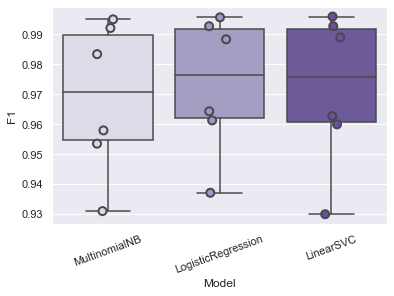

In [27]:
ax = sns.boxplot(x='Model', y='F1', data=methods, palette="Purples")
sns.stripplot(x='Model', y='F1', data=methods,
              size=8, jitter=True, edgecolor="gray", linewidth=2, palette="Purples")
ax.set_xticklabels(ax.get_xticklabels(), rotation=20)

plt.show()

Above are the result table and plot showing a comparison between these different models after training them and see how these models perform on the test data.

Notice that Muninomial Naive Bayes does not perform as well as the other two models while Linear SVC in general out performs the others based on F1 score.

## Visualzing performance till now for each classifier across each category

Plot for Multinomial Naive Bayes regression


<AxesSubplot:title={'center':'Metrics'}, xlabel='Label'>

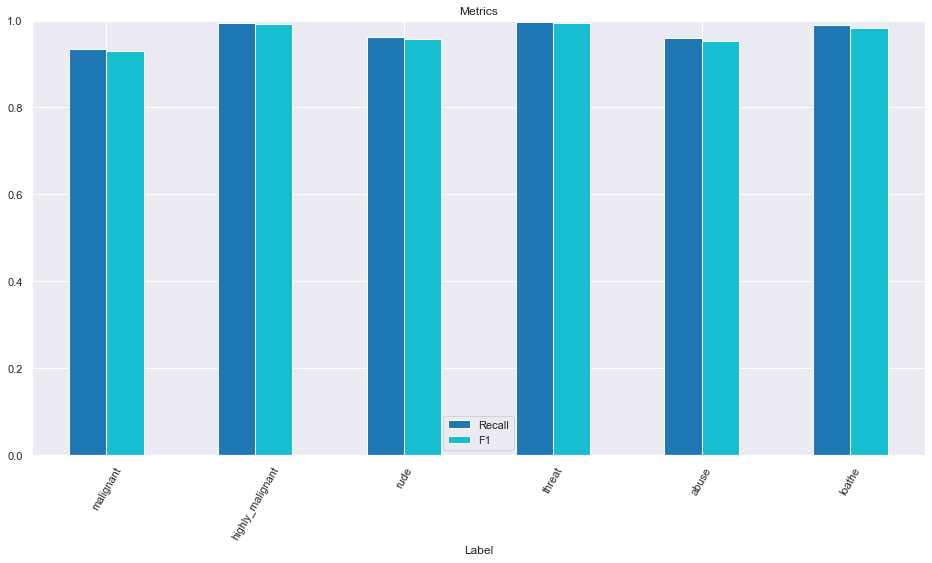

In [28]:
print("Plot for Multinomial Naive Bayes regression")
m2 = methods[methods.Model == 'MultinomialNB']

m2.set_index(["Label"], inplace=True)
%matplotlib inline
m2.plot(figsize=(16, 8), kind='bar', title='Metrics',
        rot=60, ylim=(0.0, 1), colormap='tab10')

Plot for Logistic regression


<AxesSubplot:title={'center':'Metrics'}, xlabel='Label'>

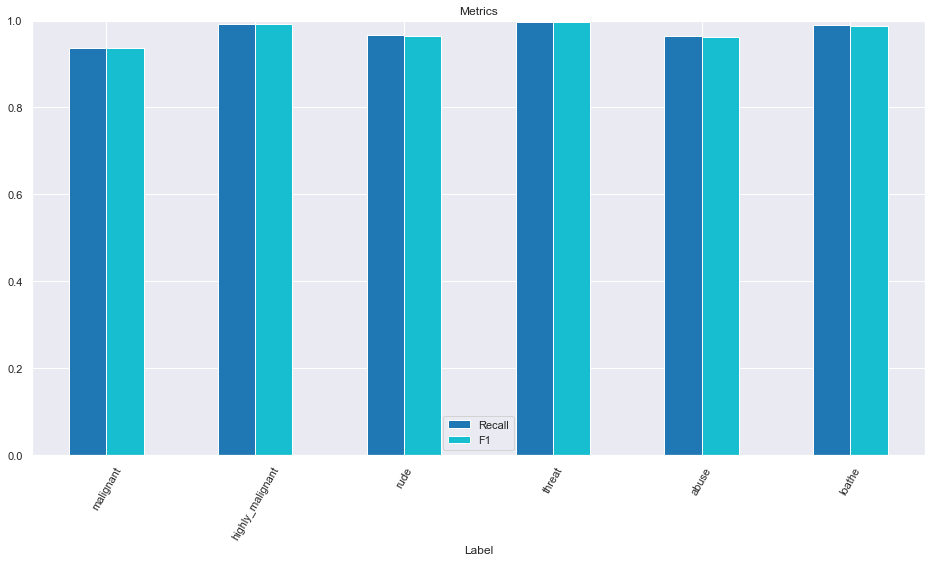

In [29]:
print("Plot for Logistic regression")
m2 = methods[methods.Model == 'LogisticRegression']

m2.set_index(["Label"], inplace=True)
%matplotlib inline
m2.plot(figsize=(16, 8), kind='bar', title='Metrics',
        rot=60, ylim=(0.0, 1), colormap='tab10')

Plot for Linear SVC


<AxesSubplot:title={'center':'Metrics'}, xlabel='Label'>

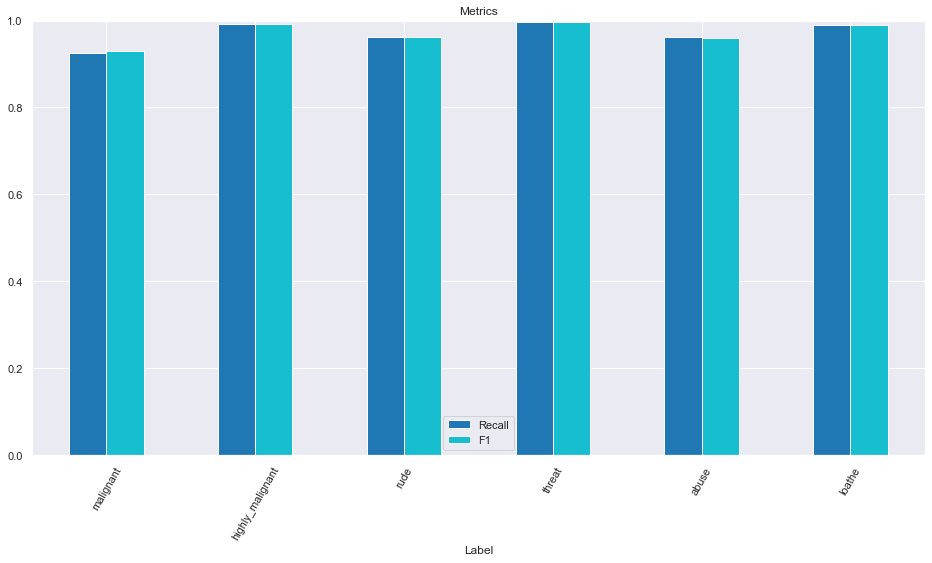

In [30]:
print("Plot for Linear SVC")
m2 = methods[methods.Model == 'LinearSVC']

m2.set_index(["Label"], inplace=True)
%matplotlib inline
m2.plot(figsize=(16, 8), kind='bar', title='Metrics',
        rot=60, ylim=(0.0, 1), colormap='tab10')

## Confusion Matrix visualization

In [31]:
def drawConfusionMatrix(cm):
    
    cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    ax = plt.axes()
    sns.heatmap(cm,
                annot=True,
                annot_kws={"size": 16},
                cmap="Purples",
                fmt='.2f',
                linewidths=2,
                linecolor='purple',
                xticklabels=("Non-Malignant", "Malignant"),
                yticklabels=("Non-Malignant", "Malignant"))

    plt.ylabel('True', fontsize=18)
    plt.xlabel('Predicted', fontsize=18)
    plt.show()

In [32]:
def Matrix(label):
    
    print(f"*************** {label} labelling ***************")
    labels = {"malignant": 0, "highly_malignant": 1, "rude": 2,
              "threat": 3, "abuse": 4, "loathe": 5}

    pos = labels[label]
    for i in range(pos, len(meth), 6):
        print()
        print(f"****  {meth['Model'][i]}  ***")
        cm = meth['Confusion_Matrix'][i]
        drawConfusionMatrix(cm)

Below shows the confusion matrix for label malignant. Notice that all models predict Non-toxic labels pretty well because most of our data are non-toxic. However, Multinomial NB tends to predict more toxic comments to non-toxic while Linear SVC is doing a great job in classifying toxic comments.

Choose a class for the Confusion Matrix: malignant
*************** malignant labelling ***************

****  MultinomialNB  ***


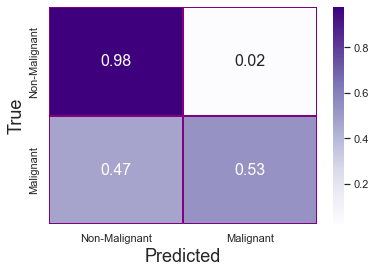


****  LogisticRegression  ***


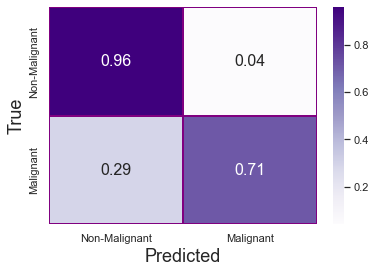


****  LinearSVC  ***


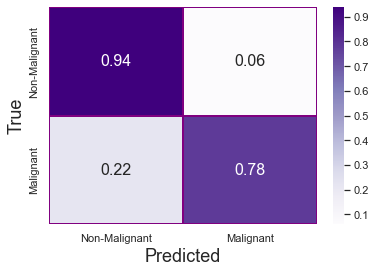

In [33]:
token = input('Choose a class for the Confusion Matrix: ')
Matrix(token.lower())

Based on the above comparison, we could say that for these three models with default settings, LinearSVC performs better than anyone for 'malignant' label .

## Aggregated Hamming Loss Score

In [34]:
hl1_df = pd.DataFrame(h1)
hl2_df = pd.DataFrame(h2)
hl3_df = pd.DataFrame(h3)

In [35]:
hammingloss = pd.concat([hl1_df, hl2_df, hl3_df])
hammingloss.columns = ['Model', 'Hamming_Loss']
hl = hammingloss.reset_index()
hl[['Model', 'Hamming_Loss']]

,Model,Hamming_Loss
0,MultinomialNB,0.026942
1,LogisticRegression,0.025660
2,LinearSVC,0.028476


Across all models , Logistic Regression is doing a great job overall since it has the lowest percentage of incorrect labels.

## Pipelines
So far we have only compared models without any hyperparameter tuning. Let's clean the code with pipeline and use some manually chosen hyperparameters to check how each model behaves. Since the greatest concern now is the imbalanced data, we decide to manually adjust class_weight for the models to see if we can achieve better results.

Since Logistic Regression and Linear SVM are performing better, we will focus on these two models. For display purpose, we will only include average F1 score, Recall, and Hamming Loss for comparison.

In [36]:
from sklearn.pipeline import Pipeline

pipe_lr = Pipeline([
    ('lr', LogisticRegression(class_weight="balanced"))
])

pipe_linear_svm = Pipeline([
    ('svm', LinearSVC(class_weight={1: 20}))
])

pipelines = [pipe_lr, pipe_linear_svm]

In [37]:
score_df = []
for pipe in pipelines:
    f1_values = []
    recall_values = []
    hl = []
    training_time = []
    predict_df = pd.DataFrame()
    predict_df['id'] = test_y['id']
    for label in test_labels:
        start = timer()
        pipe.fit(X_train, train[label])
        train_time = timer() - start
        predicted = pipe.predict(X_test)
        predict_df[label] = predicted

        f1_values.append(f1_score(
            test_y[test_y[label] != -1][label], predicted[test_y[label] != -1], average="weighted"))
        recall_values.append(recall_score(
            test_y[test_y[label] != -1][label], predicted[test_y[label] != -1], average="weighted"))
        training_time.append(train_time)
        name = pipe.steps[-1][1].__class__.__name__.split('.')[-1]

    hamming_loss_score = hamming_loss(
        test_y[test_y['malignant'] != -1].iloc[:, 1:7], predict_df[test_y['malignant'] != -1].iloc[:, 1:7])

    val = [name, mean(f1_values), mean(recall_values),
           hamming_loss_score, mean(training_time)]
    score_df.append(val)

In [38]:
scores = pd.DataFrame(score_df,)
scores.columns = ['Model', 'F1', 'Recall', 'Hamming_Loss', 'Training_Time']
scores

,Model,F1,Recall,Hamming_Loss,Training_Time
0,LogisticRegression,0.947929,0.934066,0.065934,1.756883
1,LinearSVC,0.951507,0.941634,0.058366,4.520258


Notice that after adjusting class_weight, we are getting way better results than the basic models. LinearSVC outperforms LogisticRegression by approximately 1%.

## Hyperparameter Tuning with Grid Search
Now we decide to do grid search to seek for the "optimal" hyperparameters for the basic models that we've chose. Later we will make comparison based on the best model from each algorithm, since we have 6 different lables, tuning models for each label would be time expensive, so we will use the most common label "Malignant" to tune hyperparameters.


### Logistic Regression Tuning

In [39]:
logistic_regression_classifier = LogisticRegression()

parameter_grid = {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
                  'class_weight': [None, 'balanced']}

cross_validation = StratifiedKFold(n_splits=5)

grid_search = GridSearchCV(logistic_regression_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation,
                           scoring='f1')

grid_search.fit(X_train, train['malignant'])

print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

Best parameters: {'class_weight': None, 'solver': 'newton-cg'}


LogisticRegression(solver='newton-cg')

### SVM Classifier Tuning

In [40]:
svm_classifier = LinearSVC()

parameter_grid = {'class_weight': [None, 'balanced'],
                  'C': [1, 5, 10]}

cross_validation = StratifiedKFold(n_splits=5)

grid_search = GridSearchCV(svm_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation,
                           scoring='f1')

grid_search.fit(X_train, train['malignant'])

print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

Best parameters: {'C': 1, 'class_weight': None}


LinearSVC(C=1)

### Model Selection
We will then compare these two models based on their tunned hyperparameters, we will also include training time as one of the metric when we compare models.

In [41]:
svm_clf = LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
                    intercept_scaling=1, loss='squared_hinge', max_iter=1000,
                    multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
                    verbose=0)

lr_clf = lr_clf = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                                     intercept_scaling=1, max_iter=100, multi_class='ovr',
                                     n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
                                     tol=0.0001, verbose=0, warm_start=False)

tunned_model_score_df = []
for model in [svm_clf, lr_clf]:
    f1_values = []
    recall_values = []
    hl = []
    training_time = []
    predict_df = pd.DataFrame()
    predict_df['id'] = test_y['id']

    for label in test_labels:
        start = timer()
        model.fit(X_train, train[label])
        training_time.append(timer() - start)
        predicted = model.predict(X_test)
        predict_df[label] = predicted

        f1_values.append(f1_score(test_y[test_y[label] != -1][label],
                                  predicted[test_y[label] != -1],
                                  average="weighted"))
        recall_values.append(recall_score(test_y[test_y[label] != -1][label],
                                          predicted[test_y[label] != -1],
                                          average="weighted"))
        name = model.__class__.__name__

    hamming_loss_score = hamming_loss(test_y[test_y['malignant'] != -1].iloc[:, 1:7],
                                      predict_df[test_y['malignant'] != -1].iloc[:, 1:7])

    val = [name, mean(f1_values), mean(recall_values),
           hamming_loss_score, sum(training_time)]

    tunned_model_score_df.append(val)

In [42]:
tunned_scores = pd.DataFrame(tunned_model_score_df,)
tunned_scores.columns = ['Model', 'F1',
                         'Recall', 'Hamming_Loss', 'Traing_Time']
tunned_scores

,Model,F1,Recall,Hamming_Loss,Traing_Time
0,LinearSVC,0.971706,0.971524,0.028476,2.787399
1,LogisticRegression,0.973225,0.974327,0.025673,3.729496


## Ensembling
Since Ensemble learning helps improve machine learning results by combining several models and allows the production of better predictive performance compared to a single model, we want to see if ensembling could help us achieve better results.

To ensemble different models, we firstly tried some models based on tree boosting, then use a voting classfier to ensemble one of the boosting model with the basic models in previous parts.


### Boosting Models
We tried 3 popular tree-based boosting models, and make a comparison for those models.

In [56]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [43]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
import xgboost as xgb

ab_clf = AdaBoostClassifier()
gb_clf = GradientBoostingClassifier()
xgb_clf = xgb.XGBClassifier()
boosting_models = [ab_clf, gb_clf, xgb_clf]

In [44]:
boosting_score_df = []
for model in boosting_models:
    f1_values = []
    recall_values = []
    training_time = []
    hloss = []
    predict_df = pd.DataFrame()
    predict_df['id'] = test_y['id']

    for idx, label in enumerate(test_labels):
        start = timer()
        model.fit(X_train, train[label])
        predicted = model.predict(X_test)
        training_time.append(timer() - start)
        predict_df[label] = predicted
        f1_values.append(f1_score(test_y[test_y[label] != -1][label],
                                  predicted[test_y[label] != -1],
                                  average="weighted"))
        recall_values.append(recall_score(test_y[test_y[label] != -1][label],
                                          predicted[test_y[label] != -1],
                                          average="weighted"))
        name = model.__class__.__name__

    hamming_loss_score = hamming_loss(test_y[test_y['malignant'] != -1].iloc[:, 1:7],
                                      predict_df[test_y['malignant'] != -1].iloc[:, 1:7])

    val = [name, mean(f1_values), mean(recall_values),
           hamming_loss_score, mean(training_time)]

    boosting_score_df.append(val)

[20:42:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:42:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:42:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:43:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

## Scores After Boosting the Model

In [45]:
boosting_score = pd.DataFrame(boosting_score_df,)
boosting_score.columns = ['Model', 'F1',
                          'Recall', 'Hamming_Loss', 'Traing_Time']
boosting_score

,Model,F1,Recall,Hamming_Loss,Traing_Time
0,AdaBoostClassifier,0.967605,0.969771,0.030229,20.869568
1,GradientBoostingClassifier,0.969110,0.971766,0.028234,83.909236
2,XGBClassifier,0.972674,0.973139,0.026861,13.878967


Since gradient boosting outperforms other two boosting models, we decide to go ahead with gradient boosting.

### VotingClassifier

In [46]:
ensemble_clf = VotingClassifier(estimators=[('lr', lr_clf),
                                            ('svm', svm_clf),
                                            ('xgb', xgb_clf)], voting='hard')
ensemble_score_df = []
f1_values = []
recall_values = []
hl = []
training_time = []

predict_df = pd.DataFrame()
predict_df['id'] = test_y['id']
for label in test_labels:
    start = timer()
    ensemble_clf.fit(X_train, train[label])
    training_time.append(timer() - start)
    predicted = ensemble_clf.predict(X_test)
    predict_df[label] = predicted
    f1_values.append(f1_score(test_y[test_y[label] != -1][label],
                              predicted[test_y[label] != -1],
                              average="weighted"))
    recall_values.append(recall_score(test_y[test_y[label] != -1][label],
                                      predicted[test_y[label] != -1],
                                      average="weighted"))
    name = 'Ensemble'

hamming_loss_score = hamming_loss(test_y[test_y['malignant'] != -1].iloc[:, 1:7],
                                  predict_df[test_y['malignant'] != -1].iloc[:, 1:7])

val = [name, mean(f1_values), mean(recall_values),
       hamming_loss_score, mean(training_time)]
ensemble_score_df.append(val)


# printing the values
ensemble_score = pd.DataFrame(ensemble_score_df,)
ensemble_score.columns = ['Model', 'F1',
                          'Recall', 'Hamming_Loss', 'Training_Time']
ensemble_score

[20:46:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:46:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:46:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:46:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

,Model,F1,Recall,Hamming_Loss,Training_Time
0,Ensemble,0.97326,0.973952,0.026048,15.035833


Note : Ensembled model worked very well but still could not outperform LinearSVC since we did not tune the hyperparameters for the ensemled model.

Analyzing the words misclassified by Logistic Classifier. Checking for 'toxic' label

In [47]:
label = 'malignant'
lr = LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
               intercept_scaling=1, loss='squared_hinge', max_iter=1000,
               multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
               verbose=0)
lr.fit(X_train, train[label])
Toxic_LR = lr.predict(X_test)
test_combined = pd.concat([test, test_y], axis=1)

In [48]:
commentCheck = test_combined[(test_combined.malignant == 1) & (
    Toxic_LR == 0)].comment_text
commentCheck.shape

(1347,)

Misclassified 1347 as non-toxic which were actually toxic

In [49]:
commentCheck = test_combined[(test_combined.malignant == 1) & (
    Toxic_LR == 0)].comment_text

neg_Check = pd.Series(commentCheck).str.cat(sep=' ')

In [50]:
import nltk
nltk.download('stopwords')
from collections import Counter

wrongWords = tokenize(neg_Check)
stop_words = stopwords.words('English')
wrongWords = [w for w in wrongWords if w not in stop_words]
cntr = Counter(wrongWords)
cntr.most_common(20)

[nltk_data] Downloading package stopwords to C:\Users\Rohit
[nltk_data]     Chitatwar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('bum', 352),
 ('ucking', 253),
 ('small', 244),
 ('willy', 238),
 ('goddned', 226),
 ('fgt', 226),
 ('moon', 200),
 ('like', 184),
 ('article', 184),
 ('hornyhorny', 174),
 ('stupid', 142),
 ('people', 142),
 ('derka', 140),
 ('dead', 134),
 ('know', 132),
 ('baby', 129),
 ('one', 122),
 ('wikipedia', 119),
 ('think', 116),
 ('would', 115)]

ucking is a common word in the test set and it seems our classifier hasnt learnt to classify it as toxic. Let's check how frequent was this word in the training data.

In [51]:
neg_text_train = train['comment_text'].str.cat(sep=' ')
cntr_train = Counter(tokenize(neg_text_train))
cntr_train.get('ucking')

5

It is interesting to note that this token wasn't common in our training set. That explains why our model couldn't learn it. It also gives us some food for thought on how we can improve our model further.

Let's see the features and whether this word has a high feature importance.

## Visual check how logistic learns

In [52]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(estimator,
                                                            X, y, train_sizes=train_sizes, cv=cv, n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="purple",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="steelblue",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'F:\\Anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

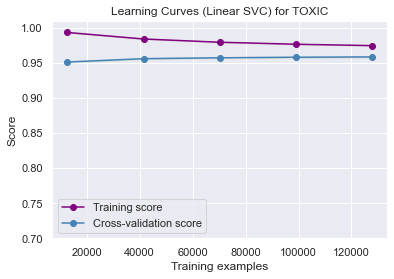

In [53]:
title = "Learning Curves (Linear SVC) for TOXIC"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
                      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
                      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
                      verbose=0)
plot_learning_curve(estimator, title, X_train,
                    train['malignant'], ylim=(0.7, 1.01), cv=cv, n_jobs=4)

# Future Improvements

Try more ways of vectorizing text data.

Go deeper on feature engineering : Spelling corrector, Sentiment scores, n-grams, etc.

Advanced models (e.g., lightgbm).

Advanced Ensemble model (e.g., stacking).

Deep learning model (e.g., LSTM).

Advanced hyperparameter tuning techniques (e.g., Bayesian Optimization).